<a href="https://colab.research.google.com/github/aliwagdy2580/NLP/blob/main/seq2seq%2Battention_NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2seq models tutorial

In this tutorial we go through the details of building seq2seq models in Keras, and explore different models for different problem setups.

This tutorial includes:
- Adding attention + visualization: Luong 


In [64]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional, Concatenate, Dot, Activation, TimeDistributed
from keras.models import Model


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data loading

In [65]:
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip -d fra-eng


--2021-09-04 17:52:42--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6451478 (6.2M) [application/zip]
Saving to: ‘fra-eng.zip.1’

fra-eng.zip.1       100%[===================>]   6.15M  5.28MB/s    in 1.2s    

2021-09-04 17:52:44 (5.28 MB/s) - ‘fra-eng.zip.1’ saved [6451478/6451478]

Archive:  fra-eng.zip
replace fra-eng/_about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: fra-eng/_about.txt      
  inflating: fra-eng/fra.txt         


In [66]:
data_path = 'fra-eng/fra.txt'
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
inputs = []
targets = []
num_samples = 10000  # Number of samples to train on.
for line in lines[: min(num_samples, len(lines) - 1)]:
  input, target, _ = line.split('\t')  
  inputs.append(input)
  targets.append(target)

In [67]:
lines=pd.DataFrame({'input':inputs,'target':targets})

In [68]:
num_samples = 10000
lines = lines[0:num_samples]


In [69]:
lines.shape

(10000, 2)

In [70]:
lines.head(10)

,input,target
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.
5,Run!,Cours !
6,Run!,Courez !
7,Run!,Prenez vos jambes à vos cous !
8,Run!,File !
9,Run!,Filez !


# Data preparation

In [71]:
def cleanup(lines):
  # Since we work on word level, if we normalize the text to lower case, this will reduce the vocabulary. It's easy to recover the case later. 
  lines.input=lines.input.apply(lambda x: x.lower())
  lines.target=lines.target.apply(lambda x: x.lower())

  # To help the model capture the word separations, mark the comma with special token:
  lines.input=lines.input.apply(lambda x:re.sub("'",'',x)).apply(lambda x: re.sub(",", ' COMMA', x))
  lines.target=lines.target.apply(lambda x:re.sub("'",'',x)).apply(lambda x: re.sub(",", ' COMMA', x))

  # Clean up punctuations and digits. Such special chars are common to both domains, and can just be copied with no error.
  exclude = set(string.punctuation)
  lines.input=lines.input.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
  lines.target=lines.target.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

  remove_digits = str.maketrans('', '', digits)
  lines.input=lines.input.apply(lambda x: x.translate(remove_digits))
  lines.target=lines.target.apply(lambda x: x.translate(remove_digits))
  #return lines
    

In [72]:
st_tok='START_'
end_tok='_END'
def data_prep(lines):
  cleanup(lines)
  lines.target=lines.target.apply(lambda x: st_tok + ' ' + x + ' ' + end_tok)

To help the model identiy the start and end of sequence, we mark them by special tokens. This will help the decoding process later:

In [73]:
data_prep(lines)

In [74]:
lines.head(10)

,input,target
0,go,START_ va _END
1,go,START_ marche _END
2,go,START_ bouge _END
3,hi,START_ salut _END
4,hi,START_ salut _END
5,run,START_ cours _END
6,run,START_ courez _END
7,run,START_ prenez vos jambes à vos cous _END
8,run,START_ file _END
9,run,START_ filez _END


# Word level model (word2word)

In this section we process the text at the word level, both for `input` and `target` domains.

In [75]:
def tok_split_word2word(data):
  return data.split()

In [76]:
tok_split_fn = tok_split_word2word

In [77]:
def data_stats(lines, input_tok_split_fn, target_tok_split_fn):
  input_tokens=set()
  for line in lines.input:
      for tok in input_tok_split_fn(line):
          if tok not in input_tokens:
              input_tokens.add(tok)
      
  target_tokens=set()
  for line in lines.target:
      for tok in target_tok_split_fn(line):
          if tok not in target_tokens:
              target_tokens.add(tok)
  input_tokens = sorted(list(input_tokens))
  target_tokens = sorted(list(target_tokens))

  num_encoder_tokens = len(input_tokens)
  num_decoder_tokens = len(target_tokens)
  max_encoder_seq_length = np.max([len(input_tok_split_fn(l)) for l in lines.input])
  max_decoder_seq_length = np.max([len(target_tok_split_fn(l)) for l in lines.target])

  return input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length



In [78]:
input_tokens,target_tokens,num_encoder_tokens,num_decoder_tokens,max_encoder_seq_length,max_decoder_seq_length=data_stats(lines,input_tok_split_fn=tok_split_fn,target_tok_split_fn=tok_split_fn)
print('Number of samples:', len(lines))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 2017
Number of unique output tokens: 4472
Max sequence length for inputs: 5
Max sequence length for outputs: 12


#Vocab

When building our vocab, we should keep a special entry for the PAD 

1.   List item
2.   List item

token, _always_ at the entry 0 of the vocab table. Of course this only happens when we pad with 0's. In general the padded token should be reserved, and NEVER used by any other token (otherwise we won't tell the difference between REAL 0 and PAD 0).

In [79]:
pad_tok = 'PAD'
sep_tok = ' '
special_tokens = [pad_tok, sep_tok, st_tok, end_tok] 
num_encoder_tokens += len(special_tokens)
num_decoder_tokens += len(special_tokens)

In [80]:

def vocab(input_tokens, target_tokens):
  
  input_token_index = {}
  target_token_index = {}
  for i,tok in enumerate(special_tokens):
    input_token_index[tok] = i
    target_token_index[tok] = i 

  offset = len(special_tokens)
  for i, tok in enumerate(input_tokens):
    input_token_index[tok] = i+offset

  for i, tok in enumerate(target_tokens):
    target_token_index[tok] = i+offset
   
  # Reverse-lookup token index to decode sequences back to something readable.
  reverse_input_tok_index = dict(
      (i, tok) for tok, i in input_token_index.items())
  reverse_target_tok_index = dict(
      (i, tok) for tok, i in target_token_index.items())
  return input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index

In [81]:
input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index = vocab(input_tokens, target_tokens)

# Vectorization

Also, when we vectorize, if we pad 0 (or any token), we need to set the corresponding target.

Below, we should set all `decoder_target_data` to the OHE corresponding the entry 0 (or whatever entry of PAD).

For example, if we pad with 0, and 0 is the first entry in vocab, then it's `decoder_target_data` must be [1,0,0,....0].
However, this is not needed if we use `mask_zero` in `Embedding`, or using a masking layer with LSTM, because those values wont be fed fwd anyway, and will not be considered in loss.

In [82]:
max_encoder_seq_length = 16
max_decoder_seq_length = 16

In [83]:
def init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens):
  encoder_input_data = np.zeros(
      (len(lines.input), max_encoder_seq_length),
      dtype='float32')
  decoder_input_data = np.zeros(
      (len(lines.target), max_decoder_seq_length),
      dtype='float32')
  decoder_target_data = np.zeros(
      (len(lines.target), max_decoder_seq_length, num_decoder_tokens),
      dtype='float32')
  
  return encoder_input_data, decoder_input_data, decoder_target_data

In [84]:
  encoder_input_data, decoder_input_data, decoder_target_data = init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens)


In [85]:
def vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn, target_tok_split_fn):
  encoder_input_data, decoder_input_data, decoder_target_data = init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens)
  for i, (input_text, target_text) in enumerate(zip(lines.input, lines.target)):
      for t, tok in enumerate(input_tok_split_fn(input_text)):
          encoder_input_data[i, t] = input_token_index[tok]
      encoder_input_data[i, t+1:] = input_token_index[pad_tok]
      for t, tok in enumerate(target_tok_split_fn(target_text)):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_input_data[i, t] = target_token_index[tok]         
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_target_data[i, t - 1, target_token_index[tok]] = 1.
      decoder_input_data[i, t+1:] = target_token_index[pad_tok] 
      decoder_target_data[i, t:, target_token_index[pad_tok]] = 1.          
              
  return encoder_input_data, decoder_input_data, decoder_target_data              

In [86]:
encoder_input_data, decoder_input_data, decoder_target_data  = vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)

# seq2seq + Attention

The vanilla seq2seq suffers a severe drawback, all the decoded outputs are initiated from the _final_ internal state of the encoder. The objective is to mimic the reading process in humans, where the whole sequence is comprehended first, then translation (decoding) happens based on that. 

However, it is clear that, even we as humans will not generate the whole translations without looking back at the _concerned_ parts of the input text. In other words, every translated word is usually generated by _attending_ to certain words in the input, in sequence.

So it is better to _condition_ the decoded words on certain words of the input. But who decides which words to attend to when generating/decoding output word?

The decoder LSTM will have the following inputs:
- previous outputs $y_{t-1}$
- state composed of concatenation of:

1- previous state $s_{t-1}$ = $[h_{t-1}, C_{t-1}]$

2- context vector $c_t$ = weighted/gated encoder states $h_j$ = $\sum_{j=0}^{j=T} \alpha_{tj}h_j$ 

$\alpha_{tj}$ are the ___attention___ weights. Those can be visualized as the importance of input word $j$ when decoding output word $t$:

![att_map](https://miro.medium.com/max/6400/1*T6oosC9Y9vS5AIh4GzcsNQ.png)


__How to find those weights?__

The alphas can be learnable. However, they must be related somehow to the simialrity between input word $j$ and output word $t$.

In the paper [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473), this simialrity measure was _leaned_ using a feedforward NN $a$, which generates a score $e_{tj}$ based on leanable weights over the last decoder state and the encoder state: $e_{tj} = a(s_{t-1}, h_j)$. Those scores are then normalized via simple _softmax_.




## Luong attention
In [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025), other simialrity measures are studied to encode the _attention map weights_ or $\alpha_{tj}$. Three simialrity scores $e_{tj}$are studied:
- general = weighted dot product
- concat = Bahdanau (weighted dot + tanh)
- dot = simple dot product

Again, the alphas are just simple softmax: $\alpha_{tj} = softmax(e_{tj})$ over $j \in [0,T]$ in the encoder state $h_j$
Moreover, in Bahdanaus, in Bi-LSTM, both directions states are concatenated. While in Luong, only the top one is used.

![Luing_vs_Bahdanau](https://miro.medium.com/max/1184/1*KBKsDHiUBM__dxRV31wZpw.png)

In our experiments, we adopt the simpler Luong, with dot configuration.

In [87]:
emb_sz = 256

In [88]:
def seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, emb_sz, mask_zero=True)(encoder_inputs)    
    
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # init LSTM  forword and LSTM backword
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_decoder_tokens, emb_sz, mask_zero=True)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])

    # Has another weight + tanh layer as described in equation (5) of the paper

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

    print('encoder-decoder  model:')
    print(model.summary()) 
    
    encoder_model = Model(encoder_inputs, [encoder_outputs] + encoder_states)

    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,)) 
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]# state vector from encoder
    
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    
    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    
    # Has another weight + tanh layer as described in equation (5) of the paper
    
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model

In [89]:
model, encoder_model, decoder_model = seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz=emb_sz, latent_dim=emb_sz)


encoder-decoder  model:
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 256)    517376      input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, None, 512),  1050624     embedding_4[0][0]                
____________________________________________________________________

In [90]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=20,
          validation_split=0.05)

Epoch 1/20
75/75 [==============================] - 24s 151ms/step - loss: 1.4109 - acc: 0.3772 - val_loss: 1.5052 - val_acc: 0.3755
Epoch 2/20
75/75 [==============================] - 6s 84ms/step - loss: 1.0466 - acc: 0.4933 - val_loss: 1.3585 - val_acc: 0.4646
Epoch 3/20
75/75 [==============================] - 6s 85ms/step - loss: 0.9049 - acc: 0.5415 - val_loss: 1.2867 - val_acc: 0.5039
Epoch 4/20
75/75 [==============================] - 6s 84ms/step - loss: 0.8021 - acc: 0.5766 - val_loss: 1.2214 - val_acc: 0.5225
Epoch 5/20
75/75 [==============================] - 6s 85ms/step - loss: 0.7177 - acc: 0.6035 - val_loss: 1.1810 - val_acc: 0.5397
Epoch 6/20
75/75 [==============================] - 6s 84ms/step - loss: 0.6456 - acc: 0.6262 - val_loss: 1.1536 - val_acc: 0.5458
Epoch 7/20
75/75 [==============================] - 6s 84ms/step - loss: 0.5833 - acc: 0.6483 - val_loss: 1.1484 - val_acc: 0.5490
Epoch 8/20
75/75 [==============================] - 6s 83ms/step - loss: 0.5281 -

In [91]:
def decode_sequence_attention(input_seq, sep=' '):
    # Encode the input as state vectors.
    encoder_outputs, h, c = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index[st_tok]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    attention_density = []
    
    while not stop_condition:
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_tok = reverse_target_tok_index[sampled_token_index]
        decoded_sentence += sep + sampled_tok

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_tok == end_tok or
           len(decoded_sentence) > 52):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density

In [92]:
word_decoded_sents = []
for seq_index in range(5): #[14077,20122,40035,40064, 40056, 40068, 40090, 40095, 40100, 40119, 40131, 40136, 40150, 40153]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, attention = decode_sequence_attention(input_seq)
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)
    word_decoded_sents.append(decoded_sentence)

-
Input sentence: 0    go
Name: input, dtype: object
Decoded sentence:  va _END
-
Input sentence: 1    go
Name: input, dtype: object
Decoded sentence:  va _END
-
Input sentence: 2    go
Name: input, dtype: object
Decoded sentence:  va _END
-
Input sentence: 3    hi
Name: input, dtype: object
Decoded sentence:  salut _END
-
Input sentence: 4    hi
Name: input, dtype: object
Decoded sentence:  salut _END


In [93]:
def visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab, tok_split_fn, sep= ' '):

    encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')
    
    for t, word in enumerate(tok_split_fn(text)):
        encoder_input_data[0, t] = input_token_index[word]

    input_seq = encoder_input_data[0:1]

    decoded_sentence, attention_density = decode_sequence_attention(input_seq, sep)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = sns.heatmap(attention_density[:, : len(text) + 2],
        xticklabels=[w for w in tok_split_fn(text)],
        yticklabels=[w for w in tok_split_fn(decoded_sentence)])

    ax.invert_yaxis()
    plt.show()
    
    return decoded_sentence

-
Input sentence: go
GT sentence: START_ va  _END


<Figure size 432x288 with 0 Axes>

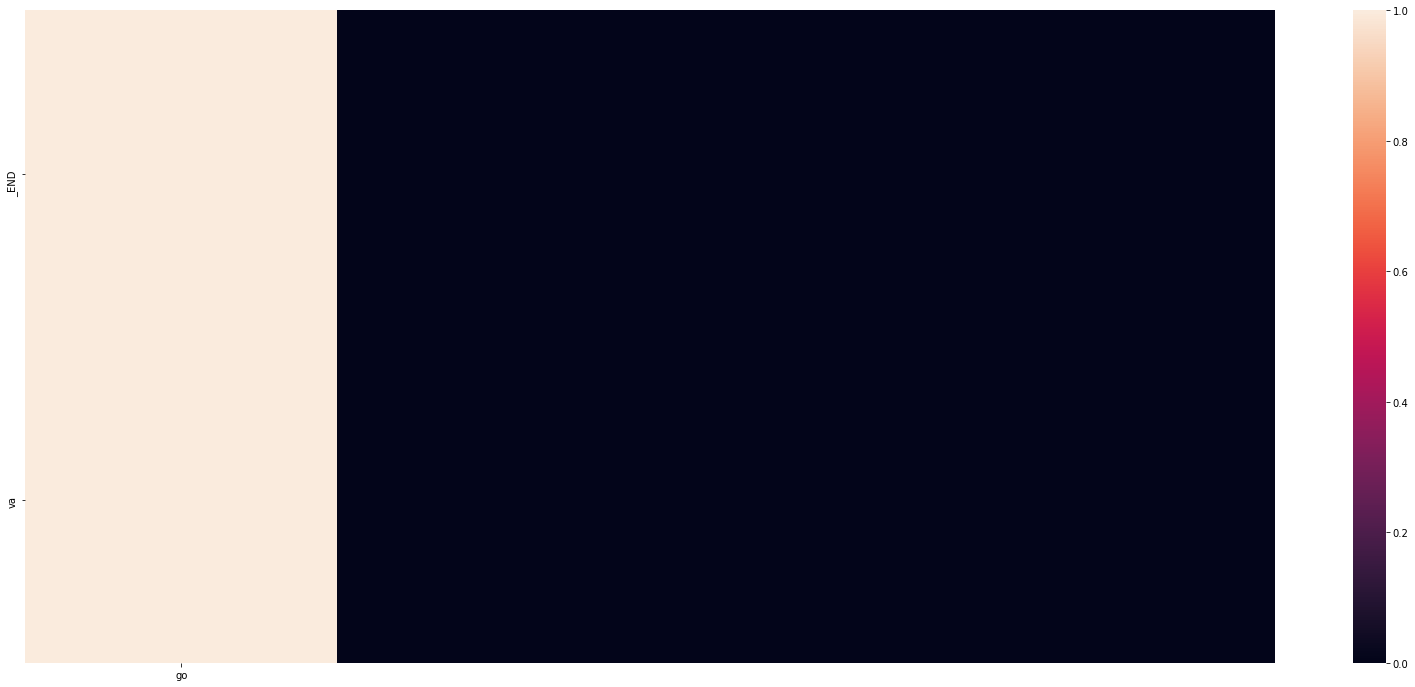

Decoded sentence:  va _END
-
Input sentence: go
GT sentence: START_ marche _END


<Figure size 432x288 with 0 Axes>

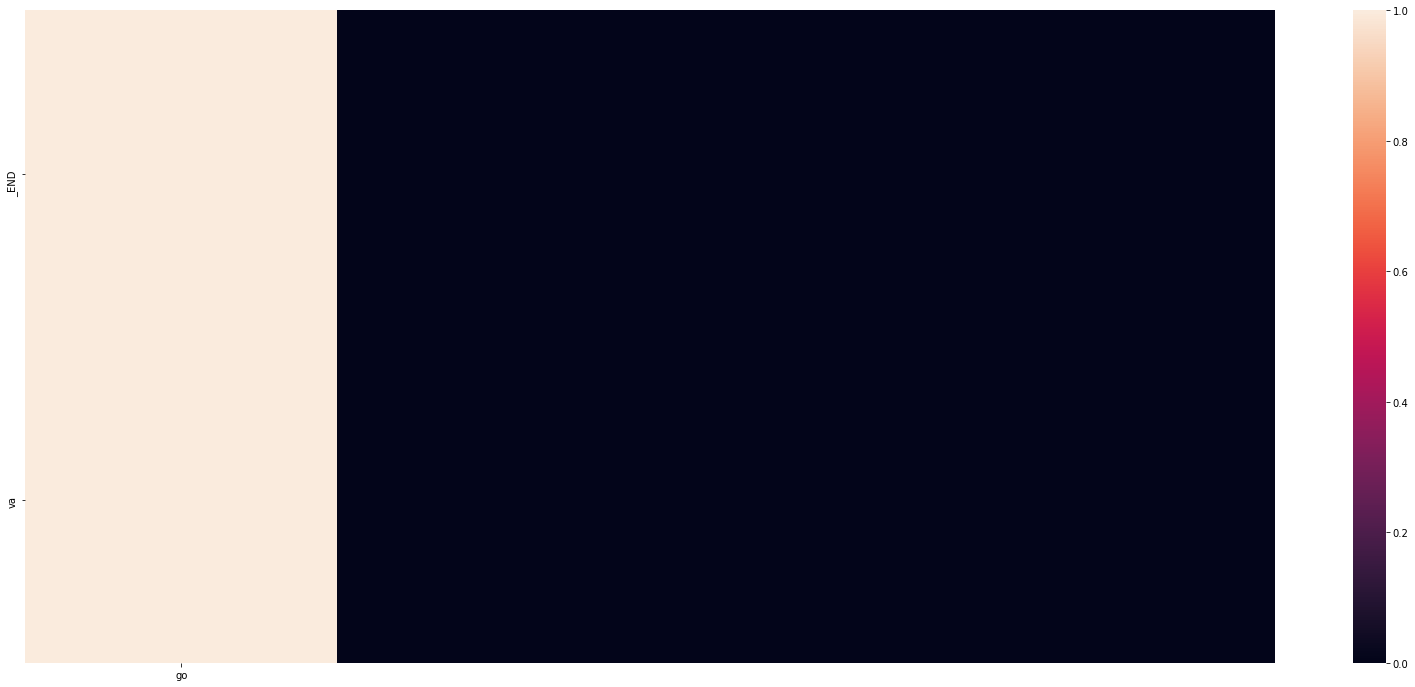

Decoded sentence:  va _END
-
Input sentence: go
GT sentence: START_ bouge  _END


<Figure size 432x288 with 0 Axes>

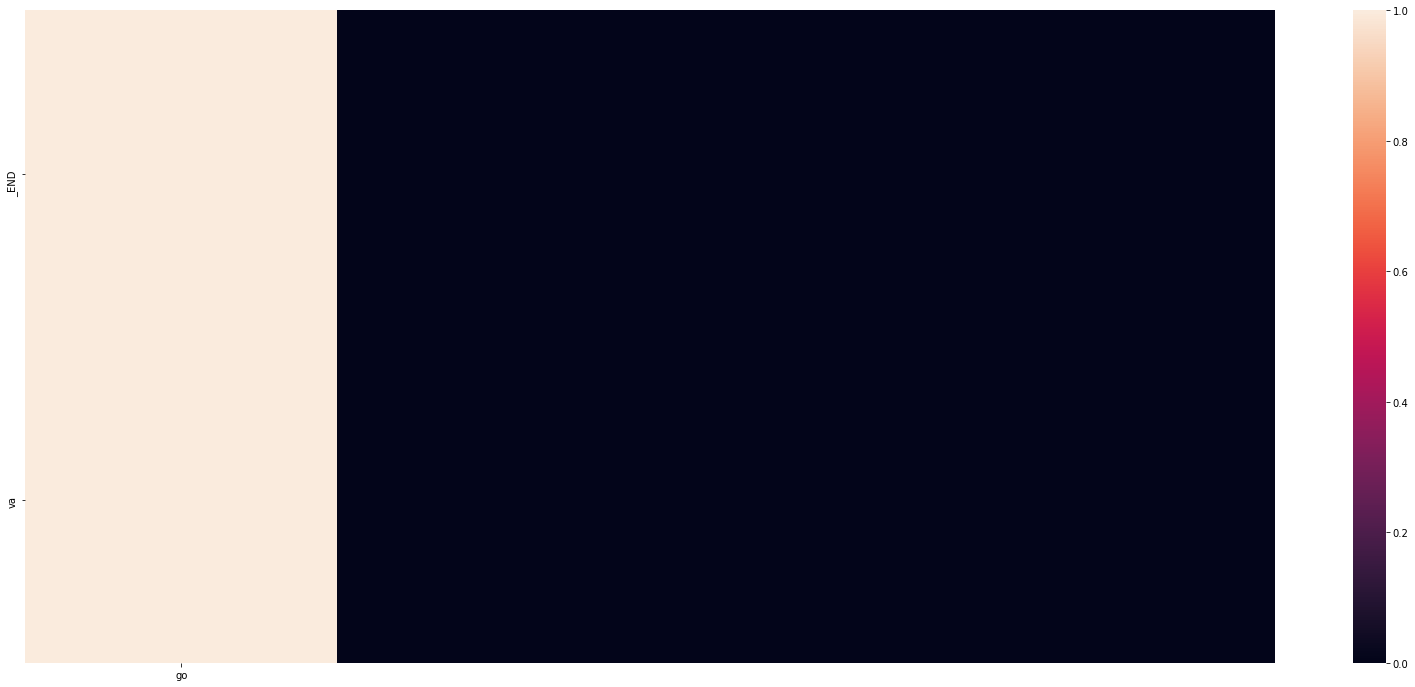

Decoded sentence:  va _END
-
Input sentence: hi
GT sentence: START_ salut  _END


<Figure size 432x288 with 0 Axes>

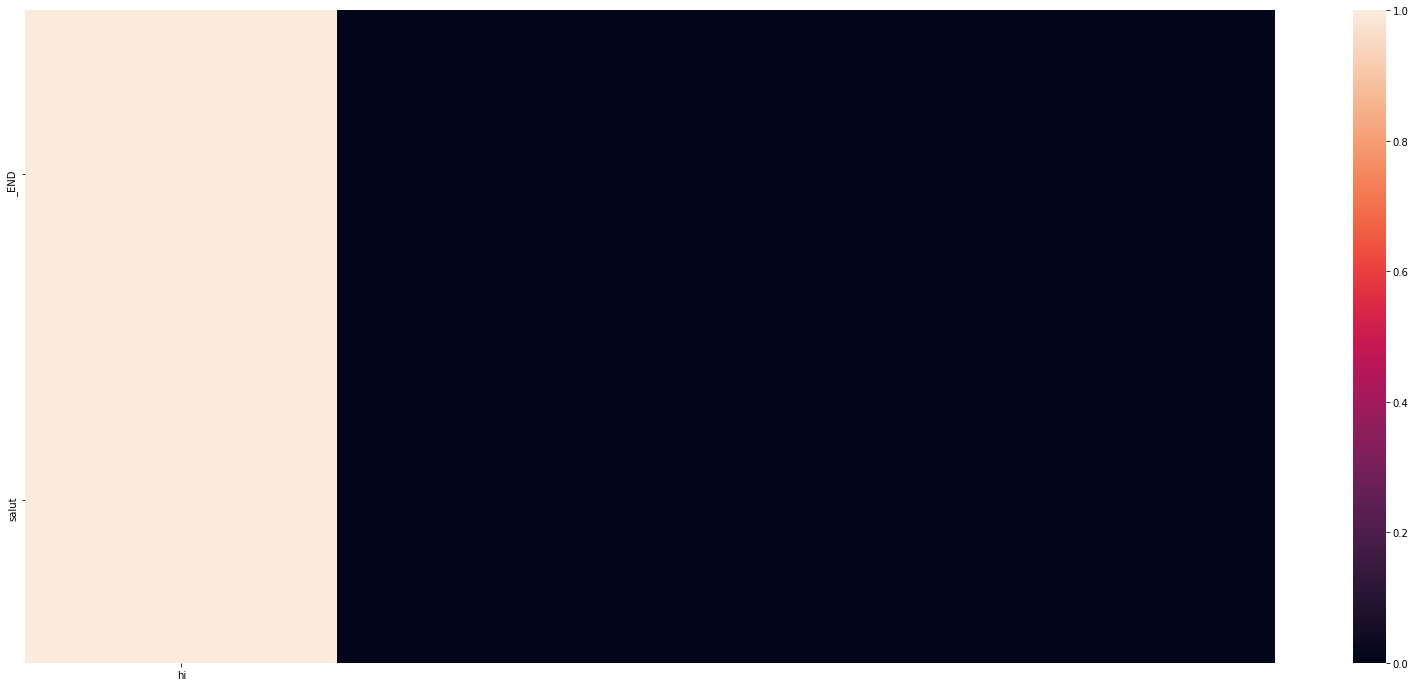

Decoded sentence:  salut _END
-
Input sentence: hi
GT sentence: START_ salut _END


<Figure size 432x288 with 0 Axes>

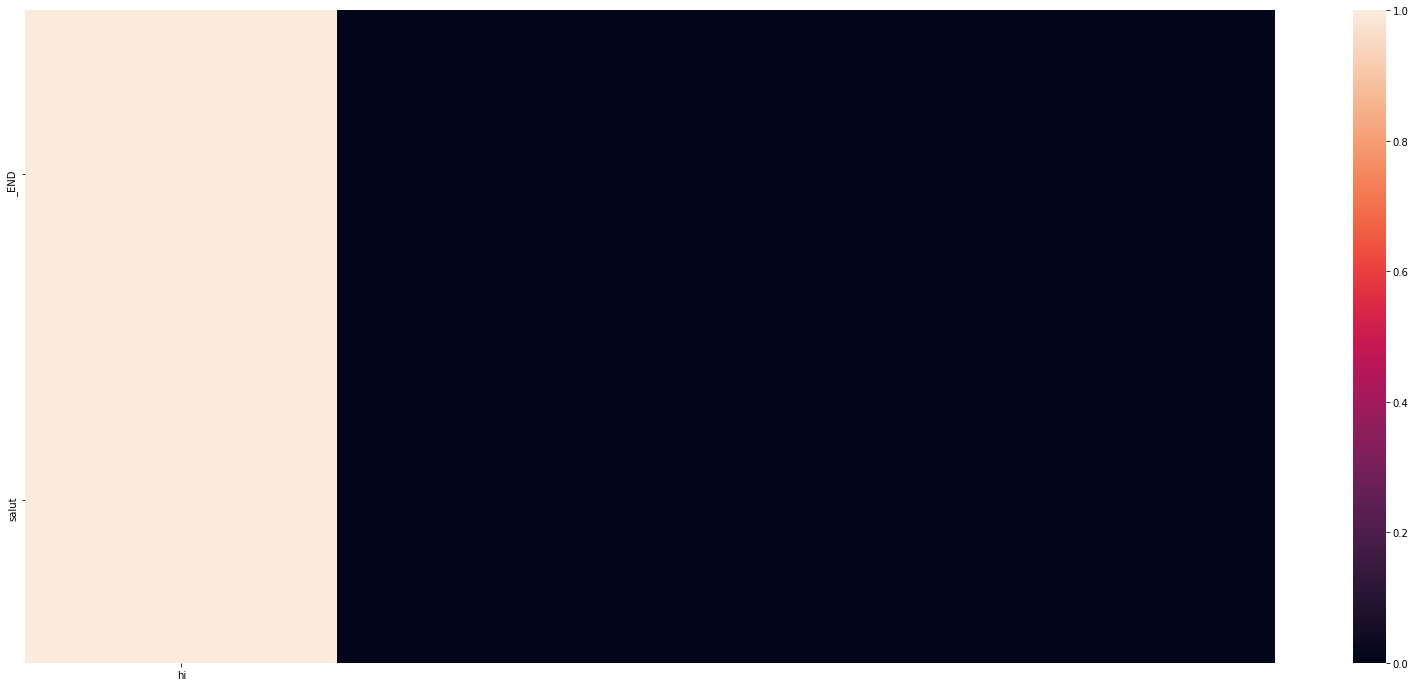

Decoded sentence:  salut _END


In [94]:
for seq_index in range(5):

    target_text = lines.target[seq_index]
    text = lines.input[seq_index]
    print('-')
    print('Input sentence:', text)    
    print('GT sentence:', target_text)
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, input_token_index, reverse_target_tok_index, tok_split_fn)

    
    print('Decoded sentence:', decoded_sentence)   


# Char Level (char2char)

Now let's encoder the sentences as sequence of chars instead of words. While it's not clear why we need to do that in NMT application, the need is more clear in other applications that has the possibility of having mistakes in the input, leading to OOV words. Examples:
- Spelling correction
- Chatbots

Char level models have the following pros:

- No OOV: we cannot encounter a char we don't know. In word level models, there's a risk of having new word not in out vocab.

- `number_target_tokens` are limited by the length of chars vocab, vs. large number of words vocab, which makes a huge softmax layer. This increase the memory and the model complexity, leading to risk of overfitting. Also, making it hard to learn ALL words softmax weights, since they are rarely encountered as output. Finally, dominant stop words might create [class imbalance issue](https://machinelearningmastery.com/what-is-imbalanced-classification/).

On the other hand, it has the following cons:

- `max_encoder_seq_len` and `max_decoder_seq_len` is longer than word level case. This makes it harder for the LSTM to learn the sequence states, leading to the following issue:

- Hallucination: since the sequence is long, the LSTM state capture is harder. Moreover, the model knows nothing about the notion of _word_, leading to: 1) invalid words and 2) invalid words sequence, since the language model now is at char level, and the sequence is long, so the errors in language modeling are higher.

- Error propagation: during inference, seq2seq models are sampled in a sequential order. The decoder inputs are now the feedback of decoder output. This leads to error propagation. The issue exists in both word and char level models. However, it is more severe in char level case, due to longer sequence, making it harder to recover. This also leads to hallucination (invalid words and/or sequence).

In [95]:
lines = pd.DataFrame({'input':inputs, 'target':targets})
num_samples = 10000
lines = lines[:num_samples]

In [96]:
st_tok = '\t'
end_tok = '\n'
def data_prep(lines):
  #cleanup(lines)
  lines.target = lines.target.apply(lambda x : st_tok  + x  + end_tok)
  

In [97]:
data_prep(lines)


In [98]:
lines[:10]

,input,target
0,Go.,\tVa !\n
1,Go.,\tMarche.\n
2,Go.,\tBouge !\n
3,Hi.,\tSalut !\n
4,Hi.,\tSalut.\n
5,Run!,\tCours !\n
6,Run!,\tCourez !\n
7,Run!,\tPrenez vos jambes à vos cous !\n
8,Run!,\tFile !\n
9,Run!,\tFilez !\n


# seq2seq + Attention

In [99]:
def tok_split_char2char(data):
  return data
  
tok_split_fn = tok_split_char2char

In [100]:
input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length = data_stats(lines, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)
print('Number of samples:', len(lines))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [101]:
pad_tok = 'PAD'
sep_tok = ' '
special_tokens = [pad_tok, sep_tok, st_tok, end_tok] 
num_encoder_tokens += len(special_tokens)
num_decoder_tokens += len(special_tokens)


In [102]:
input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index = vocab(input_tokens, target_tokens)

In [103]:
encoder_input_data, decoder_input_data, decoder_target_data  = vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)

In [104]:
model, encoder_model, decoder_model = seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz=emb_sz, latent_dim=emb_sz)
print(model.summary())


encoder-decoder  model:
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 256)    19200       input_16[0][0]                   
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, None, 512),  1050624     embedding_6[0][0]                
____________________________________________________________________

In [105]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=10,
          validation_split=0.2)

Epoch 1/10
125/125 [==============================] - 21s 86ms/step - loss: 0.7674 - acc: 0.3354 - val_loss: 0.6745 - val_acc: 0.4351
Epoch 2/10
125/125 [==============================] - 7s 52ms/step - loss: 0.5246 - acc: 0.5143 - val_loss: 0.5560 - val_acc: 0.5425
Epoch 3/10
125/125 [==============================] - 7s 52ms/step - loss: 0.4353 - acc: 0.5918 - val_loss: 0.4918 - val_acc: 0.5893
Epoch 4/10
125/125 [==============================] - 7s 52ms/step - loss: 0.3752 - acc: 0.6461 - val_loss: 0.4474 - val_acc: 0.6295
Epoch 5/10
125/125 [==============================] - 7s 53ms/step - loss: 0.3288 - acc: 0.6894 - val_loss: 0.4219 - val_acc: 0.6527
Epoch 6/10
125/125 [==============================] - 7s 53ms/step - loss: 0.2907 - acc: 0.7256 - val_loss: 0.4048 - val_acc: 0.6689
Epoch 7/10
125/125 [==============================] - 7s 52ms/step - loss: 0.2587 - acc: 0.7549 - val_loss: 0.3962 - val_acc: 0.6778
Epoch 8/10
125/125 [==============================] - 7s 53ms/step -

In [106]:
char_decoded_sents = []
target_sents = []
for seq_index in range(10): #[14077,20122,40035,40064, 40056, 40068, 40090, 40095, 40100, 40119, 40131, 40136, 40150, 40153]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, attention = decode_sequence_attention(input_seq, sep='')
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('GT sentence:', lines.target[seq_index: seq_index + 1][1:-1])
    print('Decoded sentence:', decoded_sentence)
    char_decoded_sents.append(decoded_sentence)
    target_sents.append(np.array(lines.target[seq_index: seq_index + 1]))

-
Input sentence: 0    Go.
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: Sourie.

-
Input sentence: 1    Go.
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: Sourie.

-
Input sentence: 2    Go.
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: Sourie.

-
Input sentence: 3    Hi.
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: Attendez.

-
Input sentence: 4    Hi.
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: Attendez.

-
Input sentence: 5    Run!
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: File !

-
Input sentence: 6    Run!
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: File !

-
Input sentence: 7    Run!
Name: input, dtype: object
GT 

-
Input sentence: Go.
GT sentence: 	Va !



<Figure size 432x288 with 0 Axes>

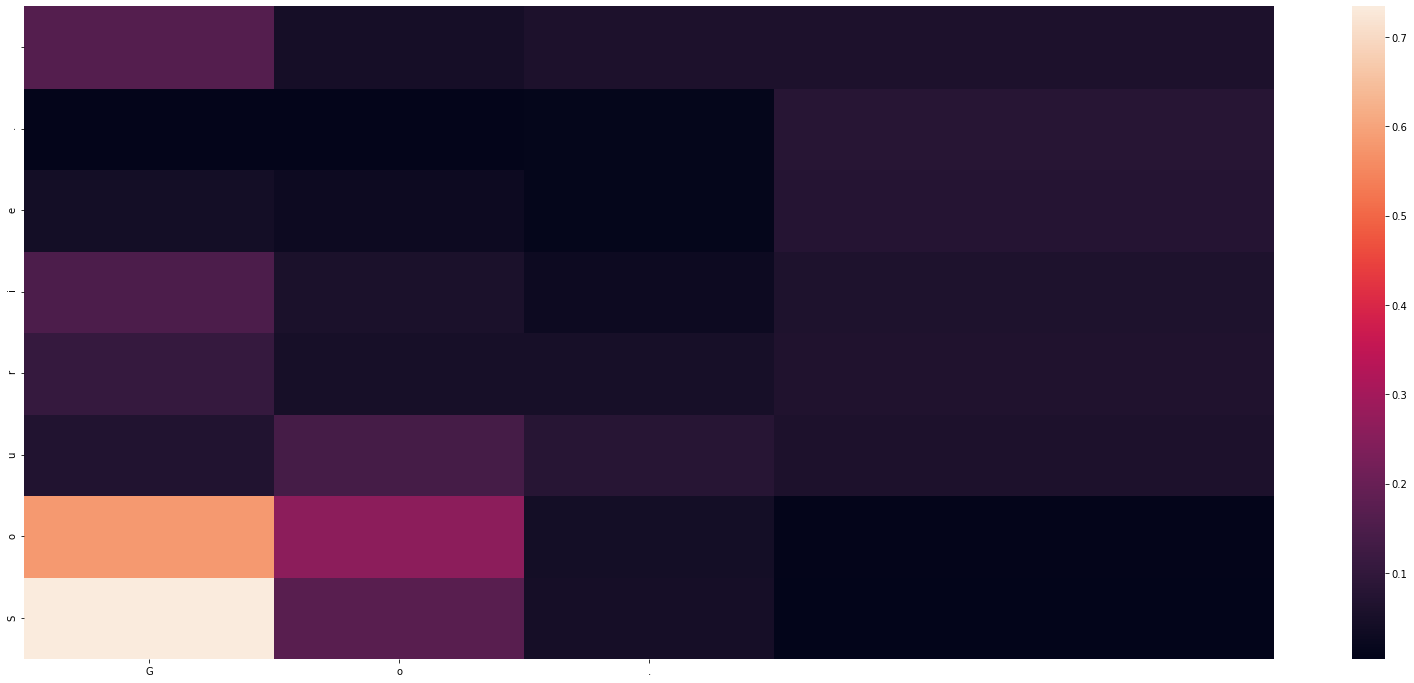

Decoded sentence: Sourie.

-
Input sentence: Go.
GT sentence: 	Marche.



<Figure size 432x288 with 0 Axes>

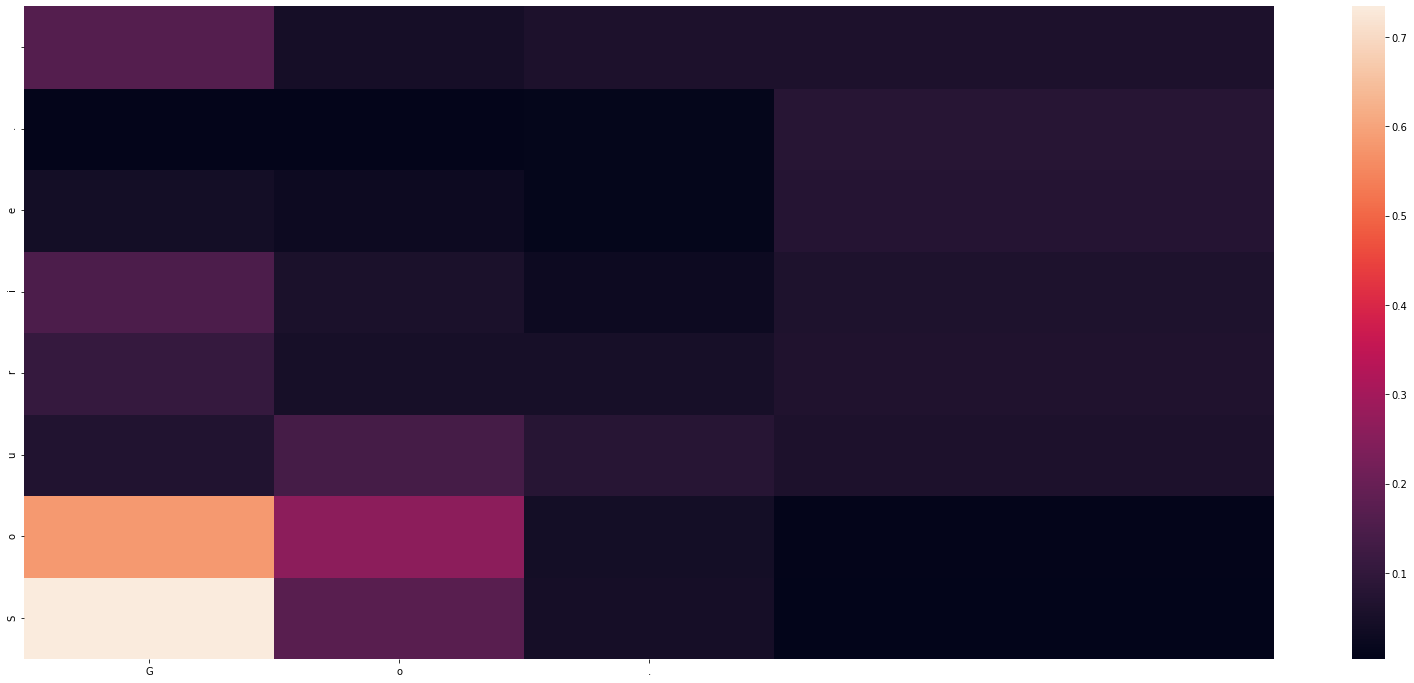

Decoded sentence: Sourie.

-
Input sentence: Go.
GT sentence: 	Bouge !



<Figure size 432x288 with 0 Axes>

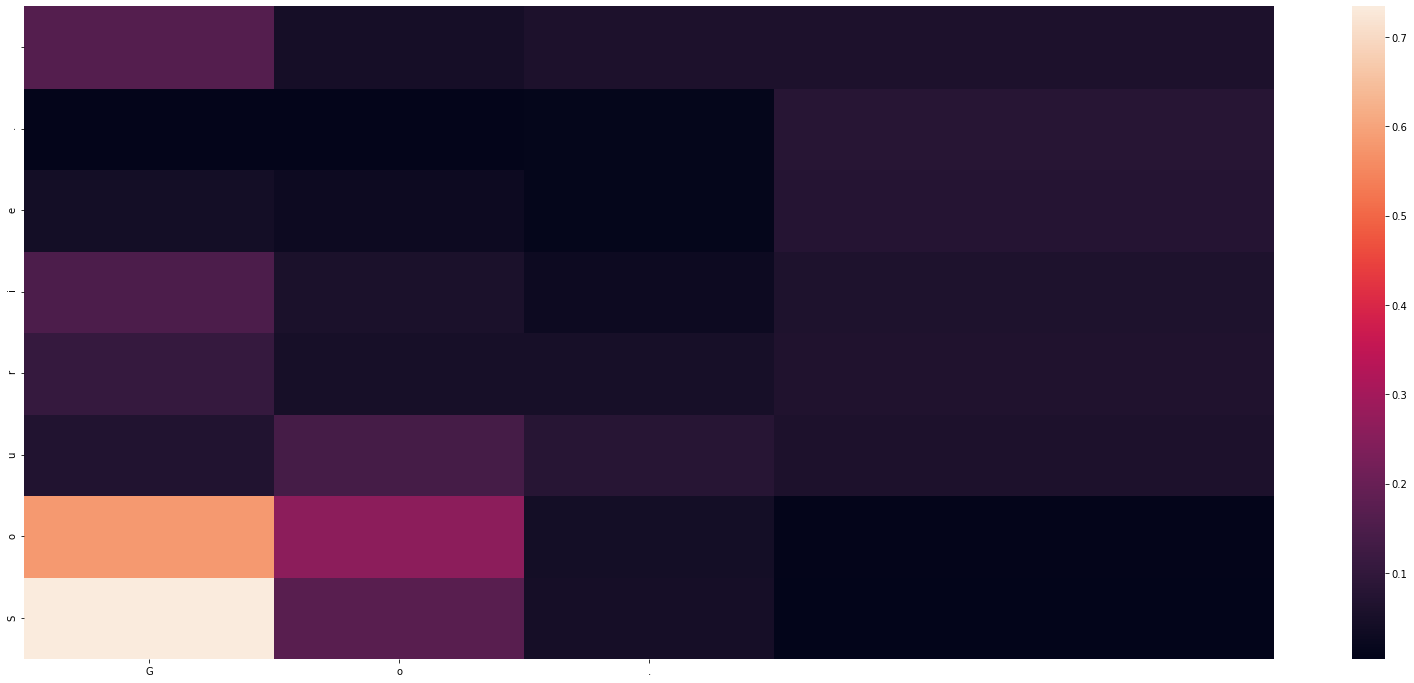

Decoded sentence: Sourie.

-
Input sentence: Hi.
GT sentence: 	Salut !



<Figure size 432x288 with 0 Axes>

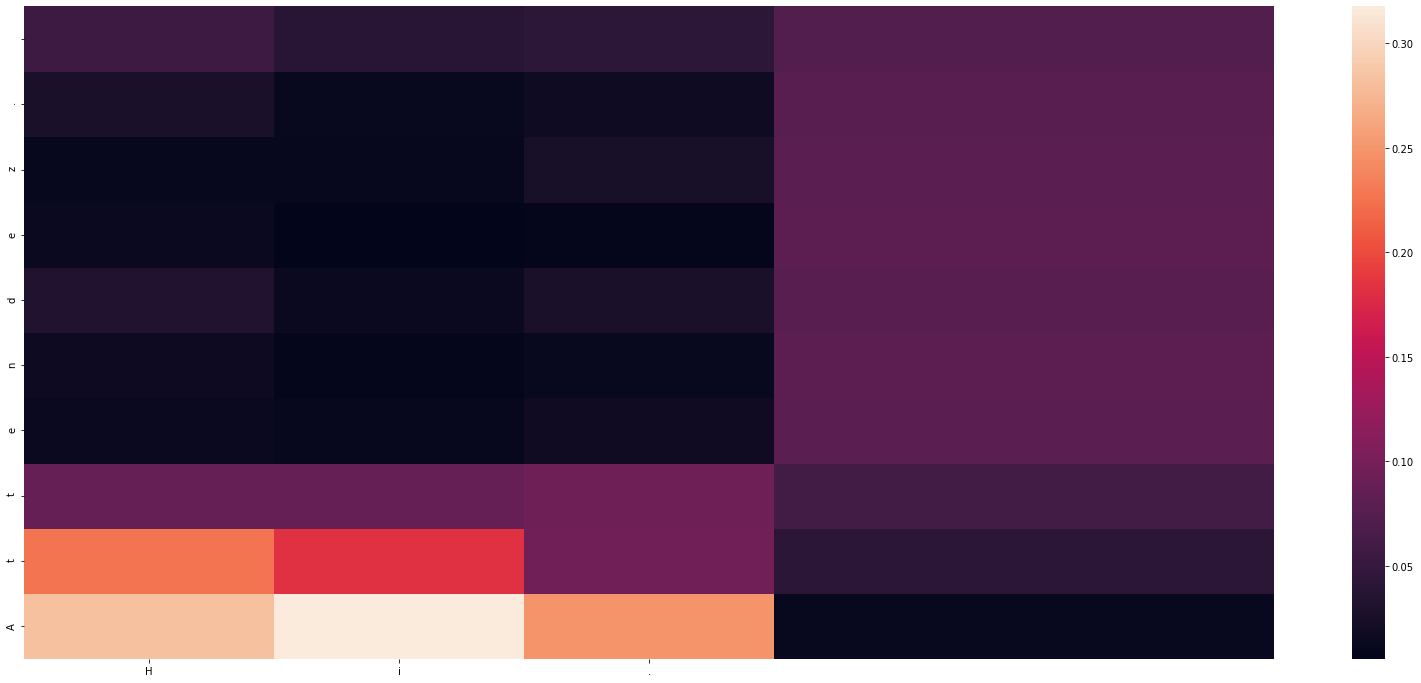

Decoded sentence: Attendez.

-
Input sentence: Hi.
GT sentence: 	Salut.



<Figure size 432x288 with 0 Axes>

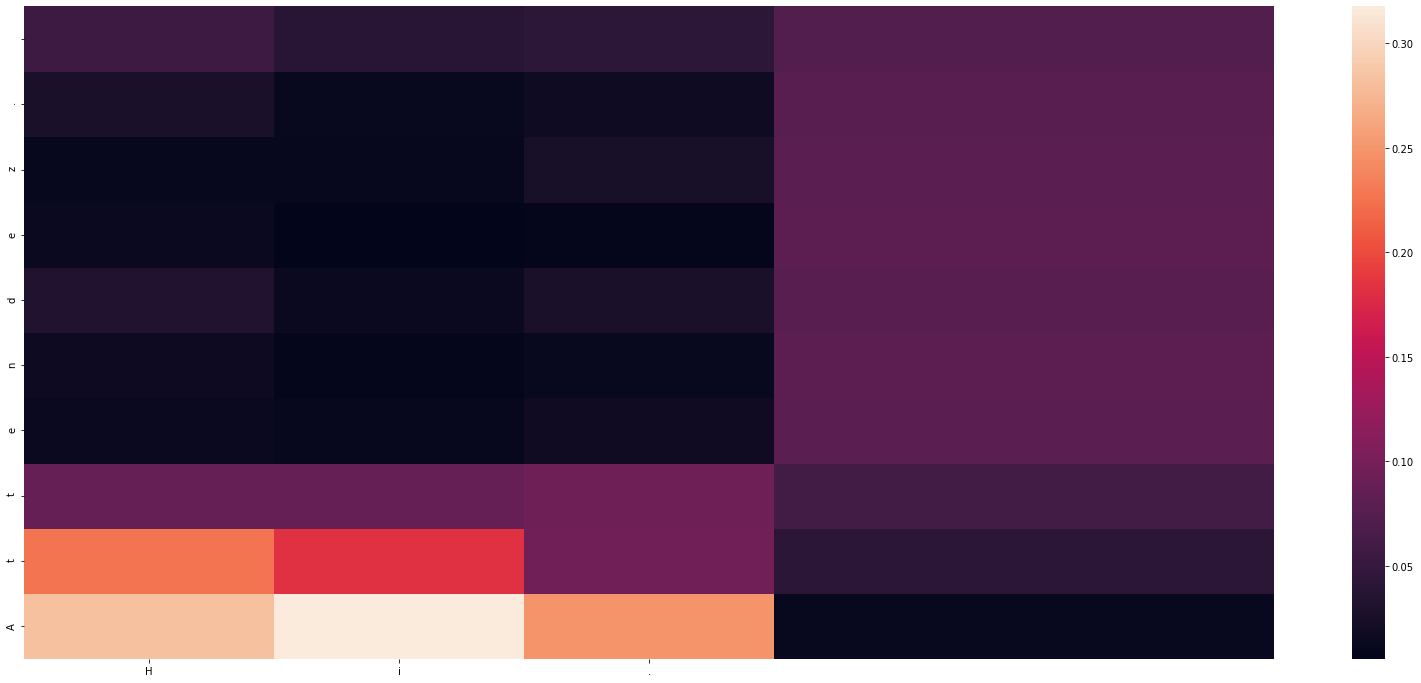

Decoded sentence: Attendez.

-
Input sentence: Run!
GT sentence: 	Cours !



<Figure size 432x288 with 0 Axes>

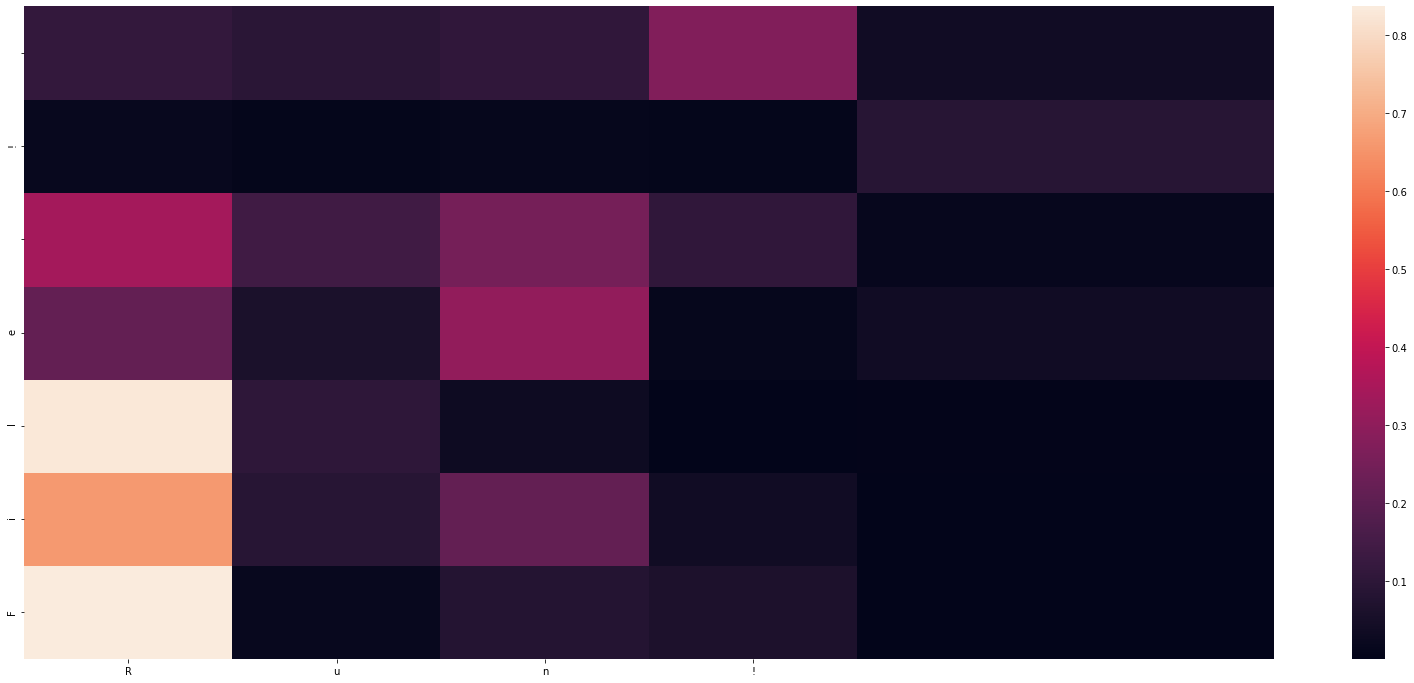

Decoded sentence: File !

-
Input sentence: Run!
GT sentence: 	Courez !



<Figure size 432x288 with 0 Axes>

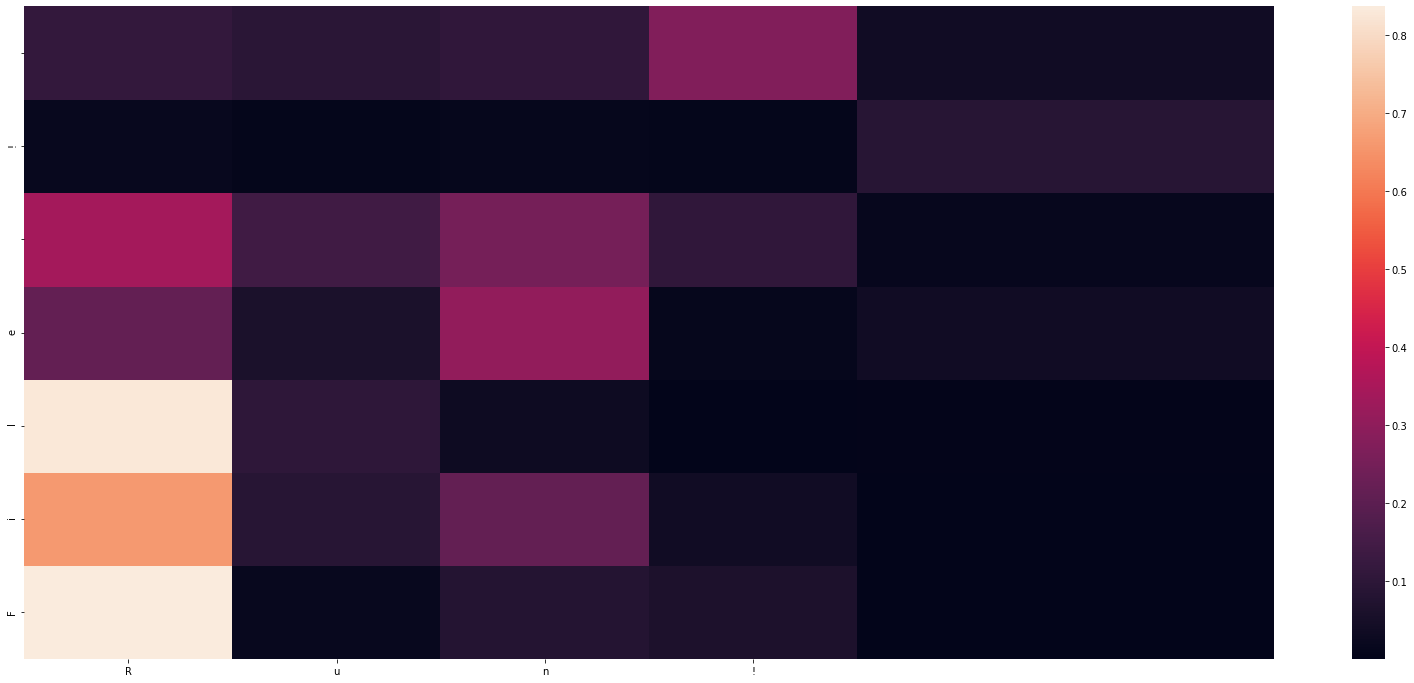

Decoded sentence: File !

-
Input sentence: Run!
GT sentence: 	Prenez vos jambes à vos cous !



<Figure size 432x288 with 0 Axes>

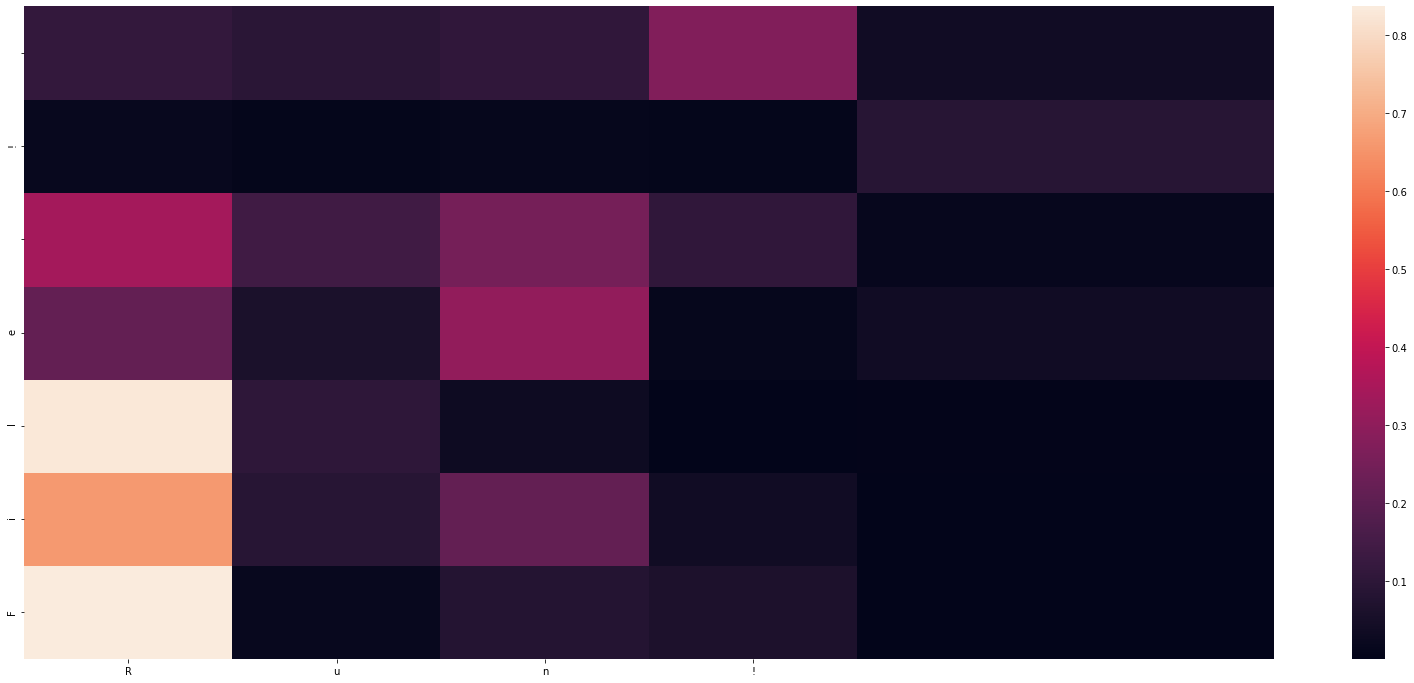

Decoded sentence: File !

-
Input sentence: Run!
GT sentence: 	File !



<Figure size 432x288 with 0 Axes>

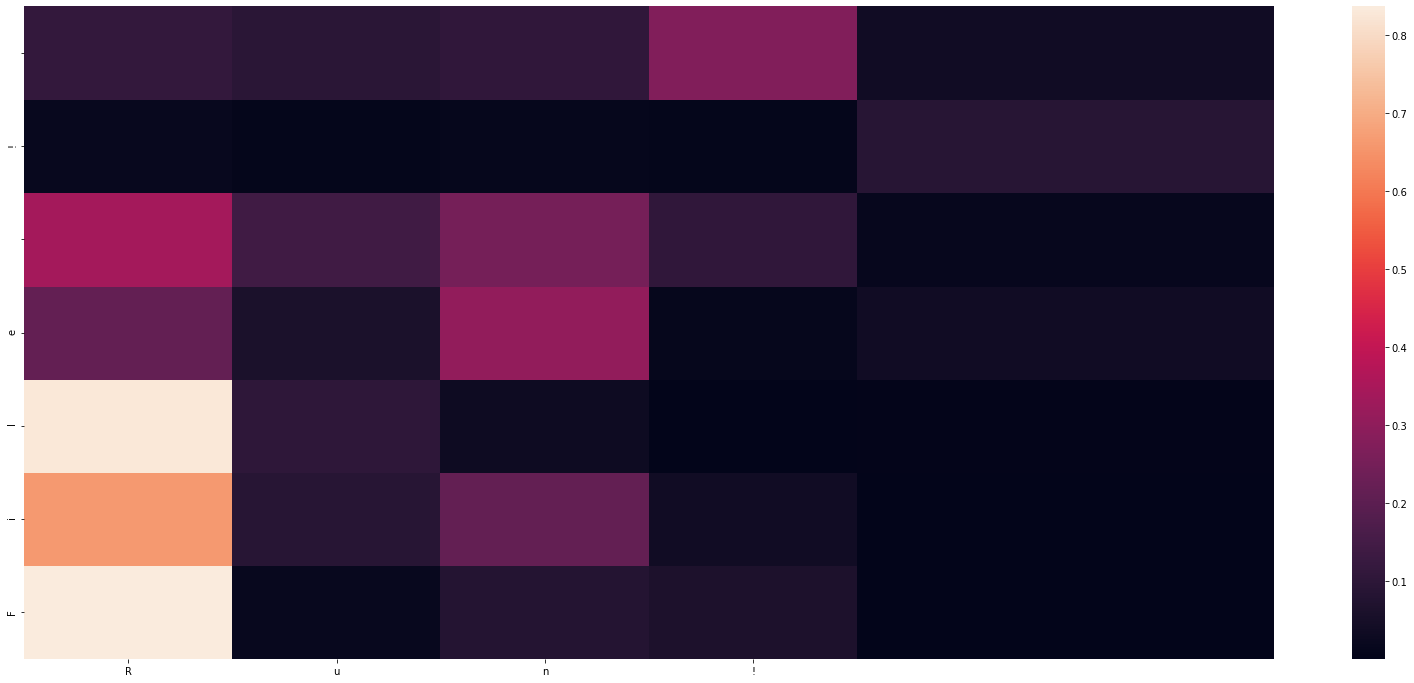

Decoded sentence: File !

-
Input sentence: Run!
GT sentence: 	Filez !



<Figure size 432x288 with 0 Axes>

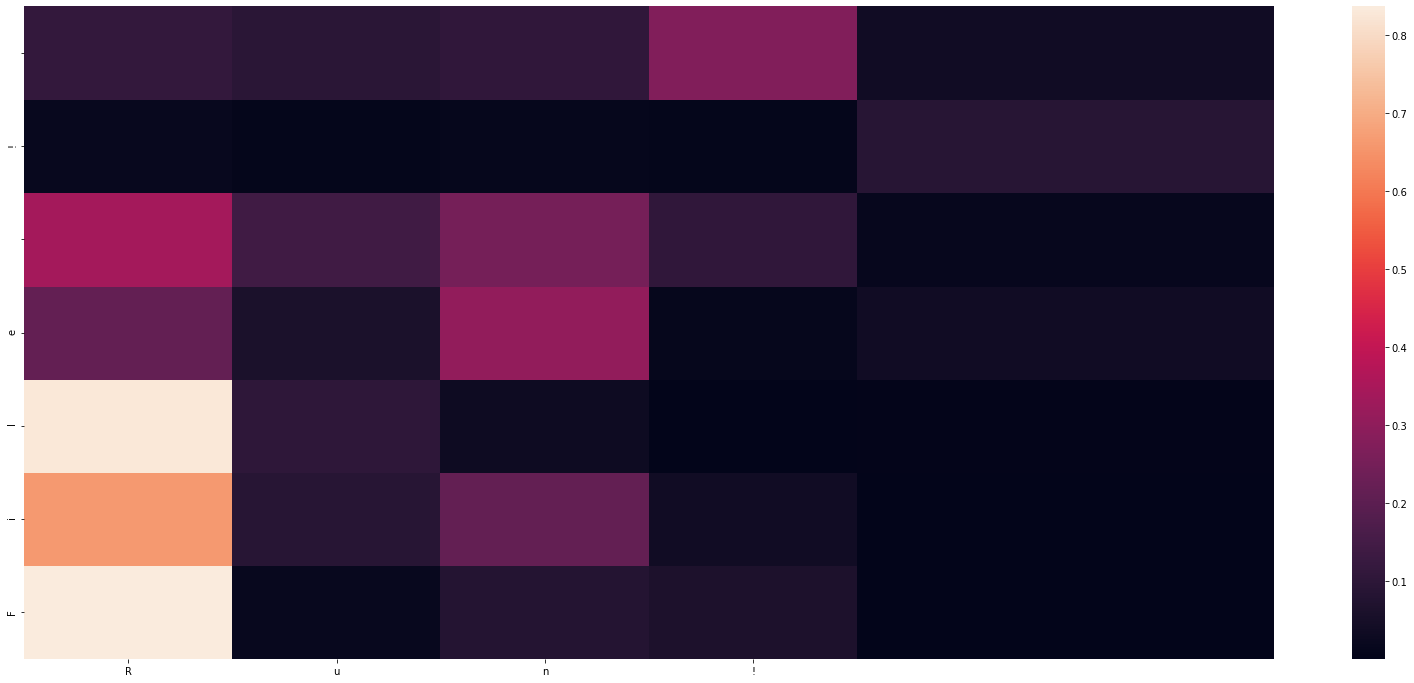

Decoded sentence: File !



In [107]:
for seq_index in range(10):

    target_text = lines.target[seq_index]
    text = lines.input[seq_index]
    print('-')
    print('Input sentence:', text)    
    print('GT sentence:', target_text)
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, input_token_index, reverse_target_tok_index, tok_split_fn, sep='')

    
    print('Decoded sentence:', decoded_sentence) 